KEGG pathways overlap

In [7]:
#Part 1: Map/merge the information by PATHWAY_ID and GENE_ID.

In [33]:
import pandas as pd

#file names
gene_file = "gene.txt"
human_file = "human.txt"

#load in files
gene_data = pd.read_csv(gene_file, sep="\t", header=None, names=["GENE_ID", "PATHWAY_ID"])
human_data = pd.read_csv(human_file, sep="\t", header=None, names=["PATHWAY_ID", "PATHWAY_NAME"])
print(gene_data.head(), human_data.head())


     GENE_ID     PATHWAY_ID
0  hsa:10327  path:hsa00010
1    hsa:124  path:hsa00010
2    hsa:125  path:hsa00010
3    hsa:126  path:hsa00010
4    hsa:127  path:hsa00010   PATHWAY_ID                                       PATHWAY_NAME
0   hsa01100          Metabolic pathways - Homo sapiens (human)
1   hsa01200           Carbon metabolism - Homo sapiens (human)
2   hsa01210  2-Oxocarboxylic acid metabolism - Homo sapiens...
3   hsa01212       Fatty acid metabolism - Homo sapiens (human)
4   hsa01230  Biosynthesis of amino acids - Homo sapiens (hu...


In [35]:
#remove 'path:' from gene_data
gene_data["PATHWAY_ID"] = gene_data["PATHWAY_ID"].str.replace("path:", "")

#Merge
merged_data = pd.merge(gene_data, human_data, on="PATHWAY_ID", how="inner")
print(merged_data.head())

rows, columns = merged_data.shape

print("Number of rows:", rows)
print("Number of columns:", columns)

     GENE_ID PATHWAY_ID                                       PATHWAY_NAME
0  hsa:10327   hsa00010  Glycolysis / Gluconeogenesis - Homo sapiens (h...
1    hsa:124   hsa00010  Glycolysis / Gluconeogenesis - Homo sapiens (h...
2    hsa:125   hsa00010  Glycolysis / Gluconeogenesis - Homo sapiens (h...
3    hsa:126   hsa00010  Glycolysis / Gluconeogenesis - Homo sapiens (h...
4    hsa:127   hsa00010  Glycolysis / Gluconeogenesis - Homo sapiens (h...
Number of rows: 37470
Number of columns: 3


In [37]:
#Part 2/3:Compute the number of overlapping genes between every 2 pathways & Save as KEGG_crosstalk.csv
from itertools import combinations
pathway_to_genes = (
    merged_data.groupby("PATHWAY_ID")["GENE_ID"]
    .apply(set) 
    .to_dict()
)

#Map Pathway names
pathway_to_name = (
    merged_data.groupby("PATHWAY_ID")["PATHWAY_NAME"]
    .first()
    .to_dict()
)

results = []

#Compute Overlaps
for (path1, genes1), (path2, genes2) in combinations(pathway_to_genes.items(), 2):
    overlap = genes1.intersection(genes2)
    if overlap:  # Only include pairs with overlaps
        results.append({
            "PATHWAY_ID1": path1,
            "PATHWAY_NAME1": pathway_to_name[path1],
            "PATHWAY_ID2": path2,
            "PATHWAY_NAME2": pathway_to_name[path2],
            "NUMBER_OF_OVERLAPPING_GENES": len(overlap),
            "LIST_OF_OVERLAPPING_GENES": ";".join(sorted(overlap))
        })

#turn it into a dataframe
results_df = pd.DataFrame(results)

#Descending Order
results_df = results_df.sort_values(by="NUMBER_OF_OVERLAPPING_GENES", ascending=False)

#Save CSV file
results_df.to_csv("KEGG_crosstalk.csv", index=False)

print(results_df.head())

      PATHWAY_ID1                                      PATHWAY_NAME1  \
19381    hsa05010           Alzheimer disease - Homo sapiens (human)   
19522    hsa05014  Amyotrophic lateral sclerosis - Homo sapiens (...   
19597    hsa05016          Huntington disease - Homo sapiens (human)   
19460    hsa05012           Parkinson disease - Homo sapiens (human)   
19519    hsa05014  Amyotrophic lateral sclerosis - Homo sapiens (...   

      PATHWAY_ID2                                      PATHWAY_NAME2  \
19381    hsa05022  Pathways of neurodegeneration - multiple disea...   
19522    hsa05022  Pathways of neurodegeneration - multiple disea...   
19597    hsa05022  Pathways of neurodegeneration - multiple disea...   
19460    hsa05022  Pathways of neurodegeneration - multiple disea...   
19519    hsa05016          Huntington disease - Homo sapiens (human)   

       NUMBER_OF_OVERLAPPING_GENES  \
19381                          339   
19522                          300   
19597               

In [ ]:
# Part 4 Compute a rank of the genes based on how many pathways they appear on and save it to a file

In [39]:
# Compute gene ranks based on the number of pathways they appear in
gene_to_pathways = (
    merged_data.groupby("GENE_ID")["PATHWAY_ID"]
    .apply(set)
    .to_dict()
)

# Create a DataFrame for gene ranks
gene_ranks = [
    {"GENE_ID": gene, "NUMBER_OF_PATHWAYS": len(pathways)}
    for gene, pathways in gene_to_pathways.items()
]

# Convert to DataFrame and sort by NUMBER_OF_PATHWAYS
gene_ranks_df = pd.DataFrame(gene_ranks).sort_values(by="NUMBER_OF_PATHWAYS", ascending=False)

# Save to a CSV file
gene_ranks_df.to_csv("KEGG_gene_ranks.csv", index=False)

print(gene_ranks_df.head())

       GENE_ID  NUMBER_OF_PATHWAYS
5742  hsa:5595                 118
5741  hsa:5594                 118
5233  hsa:5290                 106
5236  hsa:5293                 106
5234  hsa:5291                 106


In [ ]:
# 5. Retrieve a set of the pathways the top 3 genes appear on

In [43]:
# Create a dictionary mapping PATHWAY_ID to PATHWAY_NAME so that pathway names can be assigned to the IDs
pathway_name_dict = merged_data.drop_duplicates(subset="PATHWAY_ID")[["PATHWAY_ID", "PATHWAY_NAME"]]
pathway_name_dict = pathway_name_dict.set_index("PATHWAY_ID")["PATHWAY_NAME"].to_dict()

# Retrieve pathways for top 3 genes
top_genes = gene_ranks_df.head(3)["GENE_ID"].tolist()  # Ensure top_genes is a list

top_genes_pathways_ids = {}  # For storing pathway IDs
top_genes_pathways_names = {}  # For storing pathway names

for gene in top_genes:
    pathways = merged_data[merged_data["GENE_ID"] == gene]["PATHWAY_ID"].unique()
    top_genes_pathways_ids[gene] = set(pathways)
    
    # Map the pathway IDs to names using pathway_name_dict
    pathway_names = [pathway_name_dict.get(pathway_id, "Unknown pathway") for pathway_id in pathways]
    top_genes_pathways_names[gene] = set(pathway_names)

# Output results
print("Top genes and their pathway IDs:")
print(top_genes_pathways_ids)

print("\nTop genes and their pathway names:")
print(top_genes_pathways_names)



Top genes and their pathway IDs:
{'hsa:5595': {'hsa04071', 'hsa04725', 'hsa05140', 'hsa05133', 'hsa05152', 'hsa04960', 'hsa04929', 'hsa05213', 'hsa05216', 'hsa05207', 'hsa04380', 'hsa04662', 'hsa05160', 'hsa04148', 'hsa05211', 'hsa01522', 'hsa05223', 'hsa04660', 'hsa04659', 'hsa04550', 'hsa04151', 'hsa05215', 'hsa04360', 'hsa05145', 'hsa05203', 'hsa04218', 'hsa04062', 'hsa04668', 'hsa05226', 'hsa04724', 'hsa04926', 'hsa04625', 'hsa05020', 'hsa05235', 'hsa04930', 'hsa05161', 'hsa04010', 'hsa05163', 'hsa04730', 'hsa04621', 'hsa04666', 'hsa05034', 'hsa05220', 'hsa05221', 'hsa04935', 'hsa04912', 'hsa04921', 'hsa05212', 'hsa05219', 'hsa05210', 'hsa05417', 'hsa04371', 'hsa05225', 'hsa05206', 'hsa04270', 'hsa04611', 'hsa04723', 'hsa04068', 'hsa04658', 'hsa05022', 'hsa04012', 'hsa05164', 'hsa04928', 'hsa04370', 'hsa05130', 'hsa04510', 'hsa04024', 'hsa04713', 'hsa04520', 'hsa05208', 'hsa04022', 'hsa04210', 'hsa04072', 'hsa04150', 'hsa01524', 'hsa05131', 'hsa04015', 'hsa04613', 'hsa05167', 'hsa0

In [ ]:
# 6. Venn Diagram for Top 3 Genes

In [3]:
# installing matplotlib-venn for generating venn diagrams
pip install matplotlib-venn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.1-py3-none-any.whl size=45289 sha256=067909d906814ce62e6bdd8ed43701dd418f5be9cdbf4ee3fce196b81536ba37
  Stored in directory: /Users/farazhassan/Library/Caches/pip/wheels/8a/29/52/4d90d9556445079f88255b87a75d951357eff52d0795b88f4f
Successfully built matplotlib-venn
Note: you may need to restart the kernel to use updated packages.


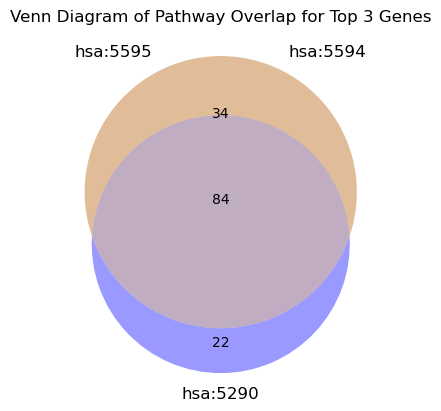

In [45]:
# Part 6: Venn Diagram for Top 3 Genes
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Prepare data for Venn diagram
top_genes_pathways_ids = {
    gene: set(merged_data[merged_data["GENE_ID"] == gene]["PATHWAY_ID"].unique())
    for gene in top_genes
}

# Extract pathway sets for Venn diagram
venn_sets = list(top_genes_pathways_ids.values())

# Create the Venn diagram
venn = venn3(
    [venn_sets[0], venn_sets[1], venn_sets[2]],
    top_genes
)

# Add title and display
plt.title("Venn Diagram of Pathway Overlap for Top 3 Genes")
plt.show()


In [ ]:
# 7a. Adding first new feature

In [ ]:
# First New Feature: Feature: Pathway Overlap Heatmap: 
# This feature visually represents the overlap of genes between pathways using a heatmap. The goal is to uncover relationships between pathways based on their shared genetic content. By highlighting these overlaps, the heatmap can reveal functional modules, pathway interactions, or redundancies within biological systems.



In [71]:
# Select the top N pathways with the most genes
top_pathways = sorted(pathway_to_genes.keys(), key=lambda x: len(pathway_to_genes[x]), reverse=True)[:20]

# Create a reduced overlap matrix for the top pathways
reduced_overlap_matrix = np.zeros((len(top_pathways), len(top_pathways)))

# Compute overlaps for the selected pathways
for i, path1 in enumerate(top_pathways):
    for j, path2 in enumerate(top_pathways):
        if i < j:
            overlap = len(pathway_to_genes[path1].intersection(pathway_to_genes[path2]))
            reduced_overlap_matrix[i, j] = overlap
            reduced_overlap_matrix[j, i] = overlap


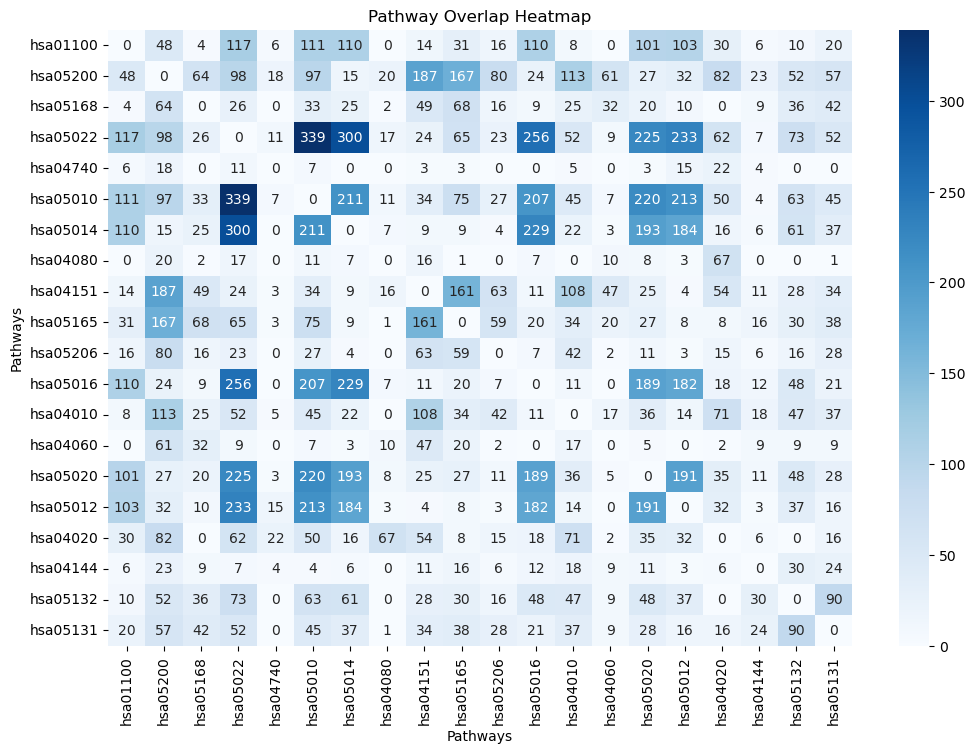

In [77]:
# Ensure data type matches the format code
overlap_df = overlap_df.astype(int)  # Convert to integers if overlaps are whole numbers

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(overlap_df, annot=True, fmt="d", cmap="Blues", cbar=True)  # Use "d" for integers
plt.title("Pathway Overlap Heatmap")
plt.xlabel("Pathways")
plt.ylabel("Pathways")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [75]:
# Find pathway pairs with high overlap
threshold = 10  # Minimum number of overlapping genes
high_overlap_pairs = [
    (path1, path2, overlap_matrix[i, j])
    for i, path1 in enumerate(pathways)
    for j, path2 in enumerate(pathways)
    if i < j and overlap_matrix[i, j] > threshold
]

# Create a DataFrame for visualization
high_overlap_df = pd.DataFrame(high_overlap_pairs, columns=["Pathway 1", "Pathway 2", "Overlap Count"])
print(high_overlap_df.sort_values(by="Overlap Count", ascending=False))


     Pathway 1 Pathway 2  Overlap Count
9008  hsa05010  hsa05022          339.0
9093  hsa05014  hsa05022          300.0
9120  hsa05016  hsa05022          256.0
9065  hsa05012  hsa05022          233.0
9090  hsa05014  hsa05016          229.0
...        ...       ...            ...
122   hsa00230  hsa04923           11.0
120   hsa00230  hsa04714           11.0
116   hsa00230  hsa04371           11.0
4928  hsa04540  hsa04660           11.0
0     hsa00010  hsa00030           11.0

[10743 rows x 3 columns]


In [83]:
# Filter pathway pairs with overlaps above a threshold
high_overlap_df = high_overlap_df[high_overlap_df["Overlap Count"] > 100]
print(high_overlap_df)


      Pathway 1 Pathway 2  Overlap Count
82     hsa00190  hsa01100          135.0
86     hsa00190  hsa04714          106.0
110    hsa00230  hsa01100          127.0
336    hsa01100  hsa01200          115.0
341    hsa01100  hsa01240          151.0
...         ...       ...            ...
10320  hsa05200  hsa05225          142.0
10321  hsa05200  hsa05226          138.0
10477  hsa05208  hsa05415          130.0
10670  hsa05224  hsa05226          114.0
10677  hsa05225  hsa05226          107.0

[84 rows x 3 columns]


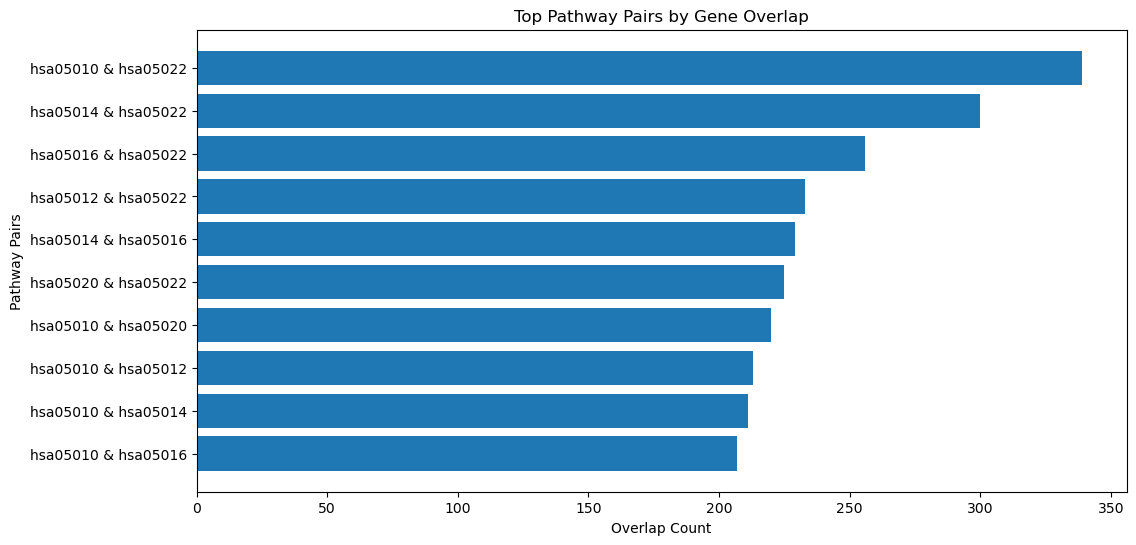

In [85]:
# Sort and get top 10 overlaps
top_pairs = high_overlap_df.sort_values(by="Overlap Count", ascending=False).head(10)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.barh(
    [f"{row['Pathway 1']} & {row['Pathway 2']}" for _, row in top_pairs.iterrows()],
    top_pairs["Overlap Count"]
)
plt.xlabel("Overlap Count")
plt.ylabel("Pathway Pairs")
plt.title("Top Pathway Pairs by Gene Overlap")
plt.gca().invert_yaxis()  # Reverse the y-axis for readability
plt.show()


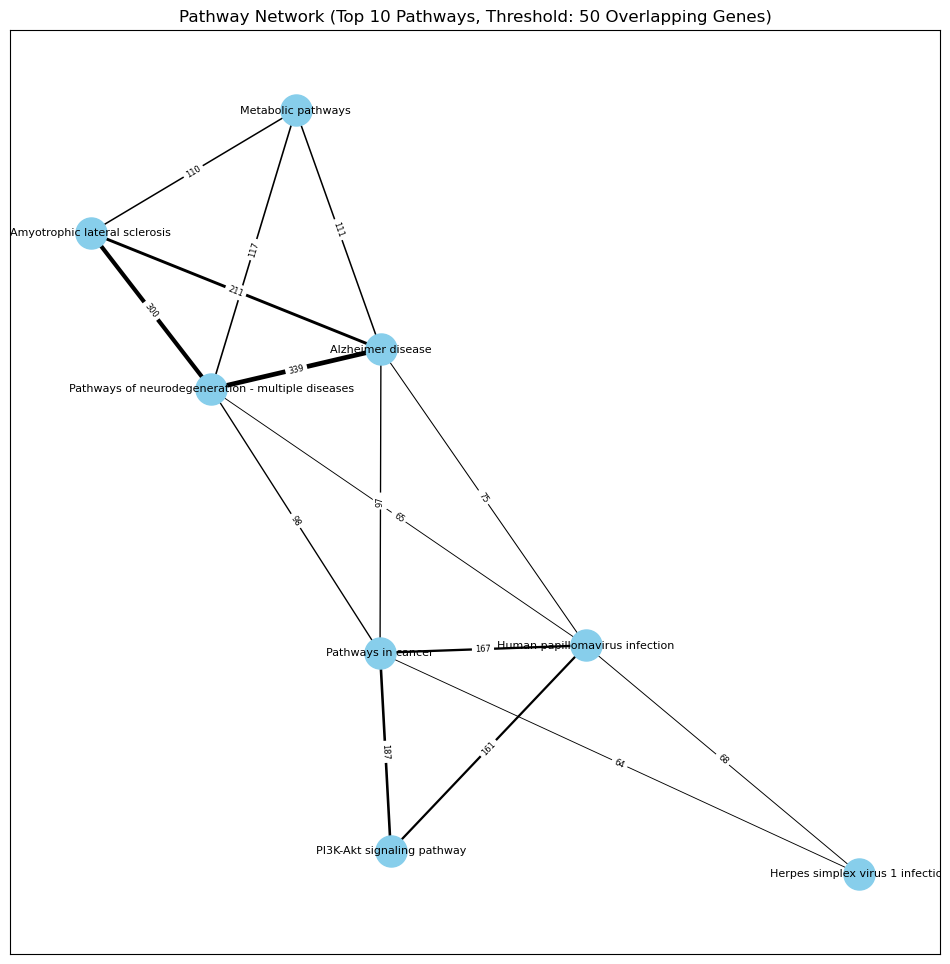

In [67]:
### Feature 2 - Network Visualization of Top N number of pathways with a threshold of 50 genes at minimum.
### Each Node represents a pathway and the edges represent the number of genes. Edges are weighted based on the number
### of genes they represent. The greater the number of edges connecting a node shows more gene overlap suggesting 
### A higher degree of similarity. 


import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Load and Clean Data
def load_data_clean_names(gene_file, human_file):
    """
    Load data from files and clean pathway names by removing ' - Homo sapiens (human)'.
    """
    gene_data = pd.read_csv(gene_file, sep="\t", header=None, names=["GENE_ID", "PATHWAY_ID"])
    human_data = pd.read_csv(human_file, sep="\t", header=None, names=["PATHWAY_ID", "PATHWAY_NAME"])
    # Clean PATHWAY_ID and PATHWAY_NAME
    gene_data["PATHWAY_ID"] = gene_data["PATHWAY_ID"].str.replace("path:", "", regex=False)
    human_data["PATHWAY_NAME"] = human_data["PATHWAY_NAME"].str.replace(" - Homo sapiens \\(human\\)", "", regex=True)
    # Merge datasets
    return pd.merge(gene_data, human_data, on="PATHWAY_ID", how="inner")

# Enrichment Analysis with Cleaned PATHWAY_NAME
def simplified_enrichment_analysis_with_names(merged_data):
    """
    Perform enrichment analysis and return pathway overlaps using PATHWAY_NAME.
    """
    pathway_to_genes = merged_data.groupby("PATHWAY_NAME")["GENE_ID"].apply(set).to_dict()
    results = []
    for (path1, genes1), (path2, genes2) in combinations(pathway_to_genes.items(), 2):
        overlap = genes1.intersection(genes2)
        if overlap:
            results.append({
                "PATHWAY_NAME1": path1,
                "PATHWAY_NAME2": path2,
                "NUMBER_OF_OVERLAPPING_GENES": len(overlap),
                "OVERLAPPING_GENES": ";".join(overlap)
            })
    return pd.DataFrame(results)

# Network Visualization with Weighted Edges and Cleaned PATHWAY_NAME
def simplified_network_with_weights(overlap_df, merged_data, max_nodes, threshold=0):
    """
    Create a simplified network visualization using cleaned PATHWAY_NAME, with edge weights based on the number of overlapping genes.
    """
    # Filter by threshold
    filtered_df = overlap_df[overlap_df["NUMBER_OF_OVERLAPPING_GENES"] >= threshold]
    
    # Count the number of genes per pathway to prioritize nodes with higher gene content
    pathway_gene_count = (
        merged_data.groupby("PATHWAY_NAME")["GENE_ID"]
        .count()
        .sort_values(ascending=False)
    )
    
    # Select top pathways based on gene count
    top_pathways = pathway_gene_count.head(max_nodes).index
    filtered_df = filtered_df[
        filtered_df["PATHWAY_NAME1"].isin(top_pathways) & filtered_df["PATHWAY_NAME2"].isin(top_pathways)
    ]
    
    # Create the graph
    G = nx.Graph()
    for _, row in filtered_df.iterrows():
        G.add_edge(
            row["PATHWAY_NAME1"],
            row["PATHWAY_NAME2"],
            weight=row["NUMBER_OF_OVERLAPPING_GENES"]  # Add edge weight
        )
    
    # Visualize the graph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")
    
    # Draw edges with weights affecting thickness
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=[w / 100 for w in weights])  # Scale weights for better visualization
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    # Add edge labels to show weights
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    
    plt.title(f"Pathway Network (Top {max_nodes} Pathways, Threshold: {threshold} Overlapping Genes)")
    plt.show()

# Example Usage
# Replace with your actual file paths
gene_file = "gene.txt"  # Gene file path
human_file = "human.txt"  # Human pathway file path

# Load and clean the data
merged_data_cleaned = load_data_clean_names(gene_file, human_file)

# Perform enrichment analysis with cleaned PATHWAY_NAME
overlap_df_with_names = simplified_enrichment_analysis_with_names(merged_data_cleaned)

# Generate network visualization with weights
max_nodes = 10  # Limit to the top 20 pathways
threshold = 50  # Set the minimum number of overlapping genes to show a connection
simplified_network_with_weights(overlap_df_with_names, merged_data_cleaned, max_nodes, threshold)
